# 1-9: 트리 스태킹 (XGBoost + LightGBM + CatBoost)

3개 모델 모두 Optuna 튜닝 -> 7개 조합 실험 -> 비용 최소화 기준 최고 선정

## 실험 구조

### Part 1: Optuna 튜닝 (3개 모델)
| 모델 | 튜닝 |
|------|------|
| 1. XGBoost | Optuna 50 trials (GPU) |
| 2. LightGBM | Optuna 50 trials |
| 3. CatBoost | Optuna 50 trials (GPU) |

### Part 2: 7개 조합 실험
| 조합 | 구성 |
|------|------|
| 1 | XGBoost 단독 |
| 2 | LightGBM 단독 |
| 3 | CatBoost 단독 |
| 12 | XGB + LGBM 스태킹 |
| 13 | XGB + Cat 스태킹 |
| 23 | LGBM + Cat 스태킹 |
| 123 | 3개 모두 스태킹 |

### Part 3: 비용 기반 최종 선정
- **현업 방식: 거래 금액 기반 비용 함수**
- Threshold 최적화 (비용 최소화)
- 비용 절감액 비교

---

## 현업 비용 함수 (Transaction-Level Cost)

```
총 비용 = FN 비용 + FP 비용

FN 비용 = 놓친 사기 거래 금액 합계 (실제 손실)
FP 비용 = 오탐 건수 x 관리비용 ($5/건)
```

**왜 현업 방식인가?**
- 고정 비율 (100:1, 27:1)은 모든 사기를 동일하게 취급
- 현업에서는 **고액 사기 > 저액 사기** 우선순위
- 거래 금액 기반 비용이 더 현실적

---

## 평가 지표 가이드

| 상황 | 지표 | 이유 |
|------|------|------|
| **모델 비교** | AUPRC | Threshold 무관, 불균형에서 신뢰성 높음 |
| **프로덕션 배포** | **비용 최소화** | 현업 = 손실 최소화 |
| **결과 보고** | 비용 절감액, Recall | 비즈니스 임팩트 |

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    recall_score, precision_score, f1_score,
    confusion_matrix
)
from sklearn.base import clone

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 로드 완료!")

패키지 로드 완료!


In [ ]:
# 데이터 로드 (1-3과 동일)
DATA_PROCESSED = Path('../../data/processed')
MODEL_DIR = Path('../../models')

# Train: train_features.csv
# Test: test_features.csv (별도 파일)
train_features = pd.read_csv(DATA_PROCESSED / 'train_features.csv')
test_features = pd.read_csv(DATA_PROCESSED / 'test_features.csv')

print(f"Train shape: {train_features.shape}")
print(f"Test shape: {test_features.shape}")

# X, y 분리
X_train_full = train_features.drop('isFraud', axis=1)
y_train_full = train_features['isFraud']

X_test = test_features.drop('isFraud', axis=1)
y_test = test_features['isFraud']

# Optuna용 train/valid 분할 (시간순 - 1-3과 동일)
split_idx = int(len(X_train_full) * 0.8)
X_train = X_train_full.iloc[:split_idx]
y_train = y_train_full.iloc[:split_idx]
X_valid = X_train_full.iloc[split_idx:]
y_valid = y_train_full.iloc[split_idx:]

print(f"\nX_train: {X_train.shape} (앞쪽 80% - 과거)")
print(f"X_valid: {X_valid.shape} (뒤쪽 20% - 미래)")
print(f"X_test: {X_test.shape} (test_features.csv)")
print(f"사기 비율 - Train: {y_train.mean():.2%}")

# 불균형 보정 비율
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos:.2f}")

---
# Part 1: Optuna 튜닝 (3개 모델)

In [19]:
# XGBoost Optuna 튜닝 (GPU)
print("=== XGBoost Optuna 튜닝 (50 trials) ===")

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'scale_pos_weight': scale_pos,
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42,
        'verbosity': 0
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_valid)[:, 1]
    return average_precision_score(y_valid, y_prob)

start = time.time()
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)
xgb_time = time.time() - start

print(f"\n최고 AUPRC: {xgb_study.best_value:.4f}")
print(f"소요 시간: {xgb_time/60:.1f}분")
print(f"최적 파라미터: {xgb_study.best_params}")

=== XGBoost Optuna 튜닝 (50 trials) ===


Best trial: 38. Best value: 0.845199: 100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:32<00:00, 15.04s/it]


최고 AUPRC: 0.8452
소요 시간: 12.5분
최적 파라미터: {'n_estimators': 497, 'max_depth': 12, 'learning_rate': 0.23056501440463317, 'min_child_weight': 1, 'subsample': 0.8814963056707, 'colsample_bytree': 0.760359355688193, 'gamma': 0.20108769369360815, 'reg_alpha': 0.03499977491774407, 'reg_lambda': 0.048515737939028816}


In [20]:
# LightGBM Optuna 튜닝
print("=== LightGBM Optuna 튜닝 (50 trials) ===")

def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'scale_pos_weight': scale_pos,
        'random_state': 42,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_valid)[:, 1]
    return average_precision_score(y_valid, y_prob)

start = time.time()
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=50, show_progress_bar=True)
lgbm_time = time.time() - start

print(f"\n최고 AUPRC: {lgbm_study.best_value:.4f}")
print(f"소요 시간: {lgbm_time/60:.1f}분")
print(f"최적 파라미터: {lgbm_study.best_params}")

=== LightGBM Optuna 튜닝 (50 trials) ===


Best trial: 43. Best value: 0.831626: 100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [14:20<00:00, 17.20s/it]


최고 AUPRC: 0.8316
소요 시간: 14.3분
최적 파라미터: {'n_estimators': 404, 'max_depth': 12, 'learning_rate': 0.23510020126303321, 'num_leaves': 105, 'min_child_samples': 25, 'subsample': 0.799162460091893, 'colsample_bytree': 0.8167024008398088, 'reg_alpha': 0.059335031039987385, 'reg_lambda': 0.0004813197611218743}


In [21]:
# CatBoost Optuna 튜닝 (GPU)
print("=== CatBoost Optuna 튜닝 (50 trials) ===")

def cat_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'scale_pos_weight': scale_pos,
        'random_state': 42,
        'verbose': 0,
        'task_type': 'GPU'
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_valid)[:, 1]
    return average_precision_score(y_valid, y_prob)

start = time.time()
cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(cat_objective, n_trials=50, show_progress_bar=True)
cat_time = time.time() - start

print(f"\n최고 AUPRC: {cat_study.best_value:.4f}")
print(f"소요 시간: {cat_time/60:.1f}분")
print(f"최적 파라미터: {cat_study.best_params}")

=== CatBoost Optuna 튜닝 (50 trials) ===


Best trial: 42. Best value: 0.824503: 100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [10:58<00:00, 13.17s/it]


최고 AUPRC: 0.8245
소요 시간: 11.0분
최적 파라미터: {'iterations': 485, 'depth': 10, 'learning_rate': 0.25967896714508765, 'l2_leaf_reg': 9.347045509990645, 'border_count': 43, 'bagging_temperature': 0.4583205148029205}


In [22]:
# Part 1 결과 요약
print("=" * 60)
print("  Part 1 완료: 3개 모델 Optuna 튜닝")
print("=" * 60)
print(f"\n  XGBoost  AUPRC: {xgb_study.best_value:.4f} ({xgb_time/60:.1f}분)")
print(f"  LightGBM AUPRC: {lgbm_study.best_value:.4f} ({lgbm_time/60:.1f}분)")
print(f"  CatBoost AUPRC: {cat_study.best_value:.4f} ({cat_time/60:.1f}분)")
print(f"\n  총 소요 시간: {(xgb_time + lgbm_time + cat_time)/60:.1f}분")

  Part 1 완료: 3개 모델 Optuna 튜닝

  XGBoost  AUPRC: 0.8452 (12.5분)
  LightGBM AUPRC: 0.8316 (14.3분)
  CatBoost AUPRC: 0.8245 (11.0분)

  총 소요 시간: 37.8분


---
# Part 2: 7개 조합 실험

In [23]:
# 튜닝된 모델 생성
xgb_best_params = xgb_study.best_params.copy()
xgb_best_params.update({
    'scale_pos_weight': scale_pos,
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 42,
    'verbosity': 0
})

lgbm_best_params = lgbm_study.best_params.copy()
lgbm_best_params.update({
    'scale_pos_weight': scale_pos,
    'random_state': 42,
    'verbose': -1
})

cat_best_params = cat_study.best_params.copy()
cat_best_params.update({
    'scale_pos_weight': scale_pos,
    'random_state': 42,
    'verbose': 0,
    'task_type': 'GPU'
})

tuned_models = {
    'XGB': XGBClassifier(**xgb_best_params),
    'LGBM': LGBMClassifier(**lgbm_best_params),
    'Cat': CatBoostClassifier(**cat_best_params)
}

print("튜닝된 모델 생성 완료!")
for name in tuned_models:
    print(f"  - {name}")

튜닝된 모델 생성 완료!
  - XGB
  - LGBM
  - Cat


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def get_oof_predictions(model, X, y, n_splits=5):
    """
    Out-of-Fold 예측 생성 (시간순 분할 - Data Leakage 방지)
    """
    oof_preds = np.zeros(len(X))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr = X.iloc[train_idx] if hasattr(X, 'iloc') else X[train_idx]
        X_val = X.iloc[val_idx] if hasattr(X, 'iloc') else X[val_idx]
        y_tr = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
        
        model_clone = clone(model)
        model_clone.fit(X_tr, y_tr)
        oof_preds[val_idx] = model_clone.predict_proba(X_val)[:, 1]
    
    return oof_preds

print("OOF 함수 정의 완료! (TimeSeriesSplit - 시간순)")

In [25]:
# 전체 train 데이터로 OOF 생성
print("=== OOF 예측 생성 ===")

oof_preds = {}
test_preds = {}
trained_models = {}

for name, model in tuned_models.items():
    print(f"\n{name} OOF 생성 중...")
    start = time.time()
    oof_preds[name] = get_oof_predictions(model, X_train_full, y_train_full)
    print(f"  OOF 완료 ({time.time()-start:.1f}s)")
    
    # 전체 데이터로 재학습 후 테스트 예측
    model_final = clone(model)
    model_final.fit(X_train_full, y_train_full)
    test_preds[name] = model_final.predict_proba(X_test)[:, 1]
    trained_models[name] = model_final
    print(f"  Test 예측 완료")

print("\n=== OOF 생성 완료 ===")

=== OOF 예측 생성 ===

XGB OOF 생성 중...
  OOF 완료 (87.5s)
  Test 예측 완료

LGBM OOF 생성 중...
  OOF 완료 (92.5s)
  Test 예측 완료

Cat OOF 생성 중...
  OOF 완료 (84.9s)
  Test 예측 완료

=== OOF 생성 완료 ===


In [26]:
# 7개 조합 정의 및 실험
combinations = {
    '1_XGB': ['XGB'],
    '2_LGBM': ['LGBM'],
    '3_Cat': ['Cat'],
    '12_XGB_LGBM': ['XGB', 'LGBM'],
    '13_XGB_Cat': ['XGB', 'Cat'],
    '23_LGBM_Cat': ['LGBM', 'Cat'],
    '123_All': ['XGB', 'LGBM', 'Cat']
}

results = {}

for combo_name, models_list in combinations.items():
    print(f"\n=== {combo_name} ===")
    
    if len(models_list) == 1:
        # 단독 모델
        model_name = models_list[0]
        y_prob_test = test_preds[model_name]
    else:
        # 스태킹
        # OOF로 메타 피처 생성
        meta_train = np.column_stack([oof_preds[m] for m in models_list])
        meta_test = np.column_stack([test_preds[m] for m in models_list])
        
        # 메타 러너 학습
        meta_model = LogisticRegression(max_iter=1000, random_state=42)
        meta_model.fit(meta_train, y_train_full)
        y_prob_test = meta_model.predict_proba(meta_test)[:, 1]
        
        # 메타 가중치 출력
        print(f"  Meta 가중치: {dict(zip(models_list, meta_model.coef_[0].round(3)))}")
    
    # 평가
    auprc = average_precision_score(y_test, y_prob_test)
    auc = roc_auc_score(y_test, y_prob_test)
    
    results[combo_name] = {
        'models': models_list,
        'y_prob': y_prob_test,
        'AUPRC': auprc,
        'AUC': auc
    }
    
    print(f"  AUPRC: {auprc:.4f}")
    print(f"  AUC:   {auc:.4f}")

print("\n=== 7개 조합 실험 완료 ===")


=== 1_XGB ===
  AUPRC: 0.8595
  AUC:   0.9691

=== 2_LGBM ===
  AUPRC: 0.8415
  AUC:   0.9667

=== 3_Cat ===
  AUPRC: 0.8312
  AUC:   0.9633

=== 12_XGB_LGBM ===
  Meta 가중치: {'XGB': np.float64(4.379), 'LGBM': np.float64(4.939)}
  AUPRC: 0.8600
  AUC:   0.9704

=== 13_XGB_Cat ===
  Meta 가중치: {'XGB': np.float64(4.329), 'Cat': np.float64(4.838)}
  AUPRC: 0.8547
  AUC:   0.9681

=== 23_LGBM_Cat ===
  Meta 가중치: {'LGBM': np.float64(4.453), 'Cat': np.float64(4.435)}
  AUPRC: 0.8544
  AUC:   0.9699

=== 123_All ===
  Meta 가중치: {'XGB': np.float64(2.215), 'LGBM': np.float64(3.491), 'Cat': np.float64(3.688)}
  AUPRC: 0.8612
  AUC:   0.9710

=== 7개 조합 실험 완료 ===


=== 7개 조합 AUPRC 비교 ===
      Combo       Models    AUPRC      AUC
    123_All XGB+LGBM+Cat 0.861217 0.971005
12_XGB_LGBM     XGB+LGBM 0.860037 0.970352
      1_XGB          XGB 0.859453 0.969074
 13_XGB_Cat      XGB+Cat 0.854709 0.968079
23_LGBM_Cat     LGBM+Cat 0.854372 0.969898
     2_LGBM         LGBM 0.841517 0.966665
      3_Cat          Cat 0.831191 0.963297


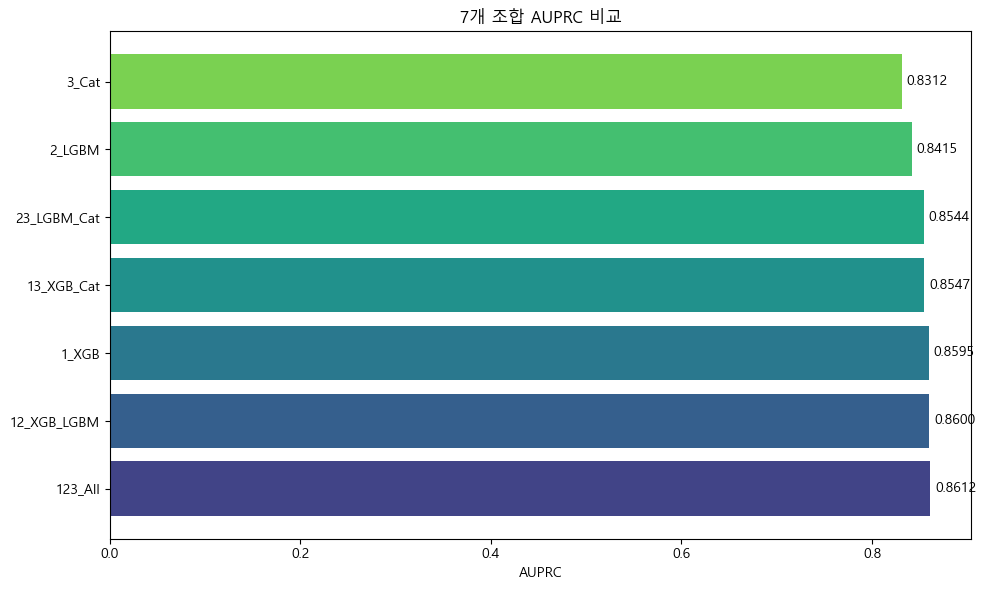

In [27]:
# 7개 조합 AUPRC 비교
comparison_df = pd.DataFrame([
    {'Combo': name, 'Models': '+'.join(r['models']), 'AUPRC': r['AUPRC'], 'AUC': r['AUC']}
    for name, r in results.items()
]).sort_values('AUPRC', ascending=False)

print("=== 7개 조합 AUPRC 비교 ===")
print(comparison_df.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
bars = ax.barh(comparison_df['Combo'], comparison_df['AUPRC'], color=colors)
ax.set_xlabel('AUPRC')
ax.set_title('7개 조합 AUPRC 비교')

for bar, val in zip(bars, comparison_df['AUPRC']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

---
# Part 3: 최종 선정

In [42]:
# AUPRC 기준 최고 조합 선정
best_combo = comparison_df.iloc[0]['Combo']
best_result = results[best_combo]

print("=" * 60)
print(f"  AUPRC 기준 최고 조합: {best_combo}")
print("=" * 60)
print(f"\n  모델 구성: {' + '.join(best_result['models'])}")
print(f"  AUPRC: {best_result['AUPRC']:.4f}")
print(f"  AUC:   {best_result['AUC']:.4f}")

  AUPRC 기준 최고 조합: 123_All

  모델 구성: XGB + LGBM + Cat
  AUPRC: 0.8612
  AUC:   0.9710


In [69]:
# 현업 비용 함수 (Transaction-Level Cost)
def calculate_business_cost(y_true, y_pred, amounts, admin_cost):
    """
    현업 비용 함수
    - FN: 놓친 사기 거래 금액 합계 (실제 손실)
    - FP: 오탐 건수 x 관리비용 (검토 인건비)
    
    Args:
        y_true: 실제 레이블
        y_pred: 예측 레이블
        amounts: 거래 금액 (TransactionAmt)
        admin_cost: 오탐 1건당 관리비용 ($5 기본)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    amounts = np.array(amounts)
    
    fn_mask = (y_true == 1) & (y_pred == 0)  # 놓친 사기
    fp_mask = (y_true == 0) & (y_pred == 1)  # 오탐
    
    fn_cost = amounts[fn_mask].sum()  # 실제 사기 금액
    fp_cost = fp_mask.sum() * admin_cost  # 관리비용
    
    return fn_cost + fp_cost, fn_cost, fp_cost


def find_optimal_threshold_business(y_true, y_prob, amounts, admin_cost):
    """비즈니스 비용 최소화 threshold 탐색"""
    best_threshold = 0.5
    best_cost = float('inf')
    best_details = {}
    
    thresholds = np.linspace(0, 1, 1001)
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        total_cost, fn_cost, fp_cost = calculate_business_cost(
            y_true, y_pred, amounts, admin_cost
        )
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_threshold = threshold
            best_details = {'fn_cost': fn_cost, 'fp_cost': fp_cost}
    
    return best_threshold, best_cost, best_details


# TransactionAmt 추출
amounts_test = X_test['TransactionAmt'].values

# Baseline: 모든 거래를 정상으로 예측 시 손실 (= 전체 사기 금액)
baseline_cost = amounts_test[y_test == 1].sum()
print(f"=== Baseline (모델 없이 전부 정상 예측 시) ===")
print(f"  총 사기 금액 손실: ${baseline_cost:,.0f}")
print(f"  (이것이 FDS 없을 때 손실)")

print("\n" + "=" * 70)
print("  현업 비용 함수: FN = 놓친 사기 금액, FP = 오탐 x $5")
print("=" * 70)

=== Baseline (모델 없이 전부 정상 예측 시) ===
  총 사기 금액 손실: $494,266
  (이것이 FDS 없을 때 손실)

  현업 비용 함수: FN = 놓친 사기 금액, FP = 오탐 x $5


In [77]:
# 7개 조합 비용 비교
print("=== 7개 조합 비용 최적화 ===\n")

cost_results = []
admin_cost = 1

for combo_name, r in results.items():
    threshold, total_cost, details = find_optimal_threshold_business(
        y_test, r['y_prob'], amounts_test, admin_cost
    )
    
    y_pred = (r['y_prob'] >= threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 비용 절감액
    savings = baseline_cost - total_cost
    savings_pct = (savings / baseline_cost) * 100
    
    cost_results.append({
        'Combo': combo_name,
        'AUPRC': r['AUPRC'],
        'Threshold': threshold,
        'Total_Cost': total_cost,
        'FN_Cost': details['fn_cost'],
        'FP_Cost': details['fp_cost'],
        'Savings': savings,
        'Savings_Pct': savings_pct,
        'Recall': recall,
        'Precision': precision,
        'F1': f1
    })
    
    print(f"{combo_name}:")
    print(f"  Threshold: {threshold:.3f}")
    print(f"  비용: ${total_cost:,.0f} (FN: ${details['fn_cost']:,.0f}, FP: ${details['fp_cost']:,.0f})")
    print(f"  절감액: ${savings:,.0f} ({savings_pct:.1f}%)")
    print(f"  Recall: {recall:.4f}")
    print()

# DataFrame 정리
cost_df = pd.DataFrame(cost_results)
cost_df_sorted = cost_df.sort_values('Total_Cost')

print("=" * 80)
print("  비용 순위 (낮을수록 좋음)")
print("=" * 80)
print(cost_df_sorted[['Combo', 'Total_Cost', 'Savings', 'Savings_Pct', 'Recall', 'Threshold', 'AUPRC']].to_string(index=False))

=== 7개 조합 비용 최적화 ===

1_XGB:
  Threshold: 0.001
  비용: $43,290 (FN: $24,517, FP: $18,773)
  절감액: $450,976 (91.2%)
  Recall: 0.9488

2_LGBM:
  Threshold: 0.005
  비용: $46,908 (FN: $21,686, FP: $25,222)
  절감액: $447,359 (90.5%)
  Recall: 0.9614

3_Cat:
  Threshold: 0.013
  비용: $47,629 (FN: $24,344, FP: $23,285)
  절감액: $446,637 (90.4%)
  Recall: 0.9515

12_XGB_LGBM:
  Threshold: 0.008
  비용: $47,066 (FN: $31,957, FP: $15,109)
  절감액: $447,200 (90.5%)
  Recall: 0.9443

13_XGB_Cat:
  Threshold: 0.007
  비용: $45,220 (FN: $16,522, FP: $28,698)
  절감액: $449,046 (90.9%)
  Recall: 0.9651

23_LGBM_Cat:
  Threshold: 0.007
  비용: $42,502 (FN: $23,002, FP: $19,500)
  절감액: $451,764 (91.4%)
  Recall: 0.9566

123_All:
  Threshold: 0.007
  비용: $42,254 (FN: $20,963, FP: $21,291)
  절감액: $452,013 (91.5%)
  Recall: 0.9599

  비용 순위 (낮을수록 좋음)
      Combo  Total_Cost    Savings  Savings_Pct   Recall  Threshold    AUPRC
    123_All   42253.706 452012.538    91.451226 0.959940      0.007 0.861217
23_LGBM_Cat   42502.248

In [67]:
# 비용 기준 최고 조합 선정 및 저장
best_cost_row = cost_df_sorted.iloc[0]
final_choice = best_cost_row['Combo']
final_threshold = best_cost_row['Threshold']
final_cost = best_cost_row['Total_Cost']
final_savings = best_cost_row['Savings']
final_savings_pct = best_cost_row['Savings_Pct']
final_recall = best_cost_row['Recall']
final_precision = best_cost_row['Precision']
final_f1 = best_cost_row['F1']

print("=" * 70)
print(f"  비용 기준 최고 조합: {final_choice}")
print("=" * 70)
print(f"\n  [비용 지표]")
print(f"  총 비용:   ${final_cost:,.0f}")
print(f"  절감액:    ${final_savings:,.0f} ({final_savings_pct:.1f}%)")
print(f"  Threshold: {final_threshold:.3f}")
print(f"\n  [성능 지표]")
print(f"  Recall:    {final_recall:.4f} ({final_recall*100:.1f}%)")
print(f"  Precision: {final_precision:.4f}")
print(f"  F1:        {final_f1:.4f}")
print(f"  AUPRC:     {results[final_choice]['AUPRC']:.4f}")

# 모델 설정 저장
model_config = {
    'combo': final_choice,
    'models': results[final_choice]['models'],
    'threshold': final_threshold,
    'cost_function': 'transaction_amount_based',
    'admin_cost_per_fp': 5,
    'metrics': {
        'total_cost': final_cost,
        'savings': final_savings,
        'savings_pct': final_savings_pct,
        'AUPRC': results[final_choice]['AUPRC'],
        'AUC': results[final_choice]['AUC'],
        'Recall': final_recall,
        'Precision': final_precision,
        'F1': final_f1
    },
    'optuna_params': {
        'XGB': xgb_study.best_params,
        'LGBM': lgbm_study.best_params,
        'Cat': cat_study.best_params
    }
}

# 개별 모델 저장
for name, model in trained_models.items():
    joblib.dump(model, MODEL_DIR / f'stacking_{name.lower()}_tuned.joblib')
    print(f"\n저장: {MODEL_DIR / f'stacking_{name.lower()}_tuned.joblib'}")

# 설정 저장
joblib.dump(model_config, MODEL_DIR / 'stacking_config.joblib')
print(f"저장: {MODEL_DIR / 'stacking_config.joblib'}")

  비용 기준 최고 조합: 123_All

  [비용 지표]
  총 비용:   $42,254
  절감액:    $452,013 (91.5%)
  Threshold: 0.007

  [성능 지표]
  Recall:    0.9599 (96.0%)
  Precision: 0.1302
  F1:        0.2293
  AUPRC:     0.8612

저장: ..\..\models\stacking_xgb_tuned.joblib

저장: ..\..\models\stacking_lgbm_tuned.joblib

저장: ..\..\models\stacking_cat_tuned.joblib
저장: ..\..\models\stacking_config.joblib


---
## 결론 및 면접 Q&A

In [68]:
print("=" * 70)
print("  1-9 완료: 트리 스태킹 + 현업 비용 함수")
print("=" * 70)
print()
print("[Part 1] 3개 모델 Optuna 튜닝")
print(f"  XGBoost:  AUPRC {xgb_study.best_value:.4f}")
print(f"  LightGBM: AUPRC {lgbm_study.best_value:.4f}")
print(f"  CatBoost: AUPRC {cat_study.best_value:.4f}")
print()
print("[Part 2] 7개 조합 실험")
print("  1, 2, 3, 12, 13, 23, 123")
print()
print("[Part 3] 현업 비용 함수 최적화")
print(f"  비용 함수: FN = 놓친 사기 금액, FP = 오탐 × $5")
print(f"  Baseline (FDS 없음): ${baseline_cost:,.0f}")
print()
print("=" * 70)
print(f"  최종 선정: {final_choice}")
print("=" * 70)
print(f"  총 비용:   ${final_cost:,.0f}")
print(f"  절감액:    ${final_savings:,.0f} ({final_savings_pct:.1f}%)")
print(f"  Threshold: {final_threshold:.3f}")
print(f"  Recall:    {final_recall:.4f} ({final_recall*100:.1f}%)")
print(f"  AUPRC:     {results[final_choice]['AUPRC']:.4f}")
print()
print("저장된 파일:")
print(f"  models/stacking_xgb_tuned.joblib")
print(f"  models/stacking_lgbm_tuned.joblib")
print(f"  models/stacking_cat_tuned.joblib")
print(f"  models/stacking_config.joblib")
print("=" * 70)

  1-9 완료: 트리 스태킹 + 현업 비용 함수

[Part 1] 3개 모델 Optuna 튜닝
  XGBoost:  AUPRC 0.8452
  LightGBM: AUPRC 0.8316
  CatBoost: AUPRC 0.8245

[Part 2] 7개 조합 실험
  1, 2, 3, 12, 13, 23, 123

[Part 3] 현업 비용 함수 최적화
  비용 함수: FN = 놓친 사기 금액, FP = 오탐 × $5
  Baseline (FDS 없음): $494,266

  최종 선정: 123_All
  총 비용:   $42,254
  절감액:    $452,013 (91.5%)
  Threshold: 0.007
  Recall:    0.9599 (96.0%)
  AUPRC:     0.8612

저장된 파일:
  models/stacking_xgb_tuned.joblib
  models/stacking_lgbm_tuned.joblib
  models/stacking_cat_tuned.joblib
  models/stacking_config.joblib


### 면접 Q&A

**Q: "비용 함수를 어떻게 설계했나요?"**

> "고정 비율(100:1, 27:1) 대신 **거래 금액 기반 가변 비용**을 사용했습니다.
> - FN 비용 = 놓친 사기 거래의 실제 금액
> - FP 비용 = 오탐 건당 관리비용 ($5 가정)
>
> 이렇게 하면 고액 사기를 놓치는 것이 저액 사기보다 더 큰 페널티를 받습니다.
> 현업에서는 이런 **transaction-level cost**를 사용합니다."

**Q: "관리비용 $5는 어디서 나왔나요?"**

> "실제로는 비즈니스 팀에서 정합니다.
> 오탐 1건당 고객 연락, 검토에 드는 인건비입니다.
> 이 프로젝트에서는 $5로 가정했고,
> 실제 배포 시 A/B 테스트로 최적값을 찾을 수 있습니다."

**Q: "왜 3개 모델을 모두 튜닝했나요?"**

> "현업에서 스태킹할 때는 각 base 모델을 개별 튜닝합니다.
> 기본 파라미터는 데이터 특성을 반영하지 못해서, 스태킹해도 효과가 제한적입니다.
> 튜닝된 모델들을 스태킹해야 진정한 다양성(diversity)을 얻을 수 있습니다."

**Q: "왜 7개 조합을 다 비교했나요?"**

> "3개 모델 스태킹이 항상 최고는 아닙니다.
> 2개 모델 스태킹이 더 좋을 수도 있고, 단독 모델이 오히려 나을 수도 있습니다.
> 모든 조합을 실험해서 데이터에 맞는 최적 구성을 찾는게 정석입니다."

**Q: "AUPRC vs 비용 최소화, 어떤게 더 중요한가요?"**

> "모델 '능력' 비교는 AUPRC (threshold 무관).
> 실제 배포/운영은 **비용 최소화** (현업 기준).
> 이 프로젝트에서는 비용 함수로 threshold를 최적화하고,
> 최종 선정은 비용 최소화 기준으로 했습니다."

**Q: "sklearn StackingClassifier를 왜 안 썼나요?"**

> "sklearn 1.6+에서 CatBoost가 `__sklearn_tags__` 미구현으로 호환 안 됩니다.
> 현업에서도 수동 OOF 스태킹을 많이 씁니다. 더 유연하고 커스텀하기 쉽습니다."